In [1]:
import os
import cbclib as cbc
import numpy as np
# import jax
# import jax.numpy as jnp
import sys
import hdf5plugin
import h5py
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump

from scripts.cbsd_numpy import (DetState, Image, Line, generate_line, Moments,
                                distance_to_streak, distance_to_line, region_grow,
                                get_bounds, project_to_line, LineBounds, Structure,
                                add_line, log_nfa, logbinom, grow_step, PixelSet, BoundList)

In [2]:
frames = np.load('results/frames.npz')['data']

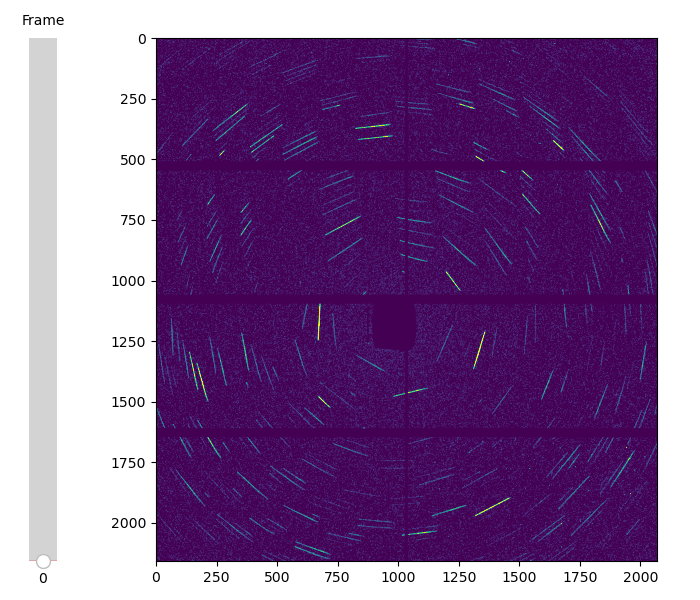

In [3]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=frames.shape[0],
                valstep=np.arange(0, frames.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(frames[0], vmin=0.0, vmax=5.0)

def update(val):
    im.set_data(frames[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [46]:
index = 18
radius, rank = 2, 3

data = cbc.src.median_filter(frames[index], (3, 3))
# data = frames[index]
data = np.abs(data)
struct = Structure.new(radius, rank)

image = Image.new(data, struct)

In [55]:
xtol, vmin = 1.0, 0.8

# x, y = 1153, 1057
x, y = 1831, 1410
# x, y = 1514, 1262

%time line = region_grow(x, y, image, struct, 200, xtol, vmin, lookahead=1)
# %time x, y, val = cbc.src.draw_line_table(line.bounds.to_line(2 * struct.radius + 1), image.shape, profile='tophat')
# %time image.update(struct, x, y, val)
# x, y = 1750, 660
# x, y = 1862, 1296

# %time line = region_grow(x, y, image, struct, 200, xtol)

CPU times: user 93.2 ms, sys: 3.16 ms, total: 96.4 ms
Wall time: 90.7 ms


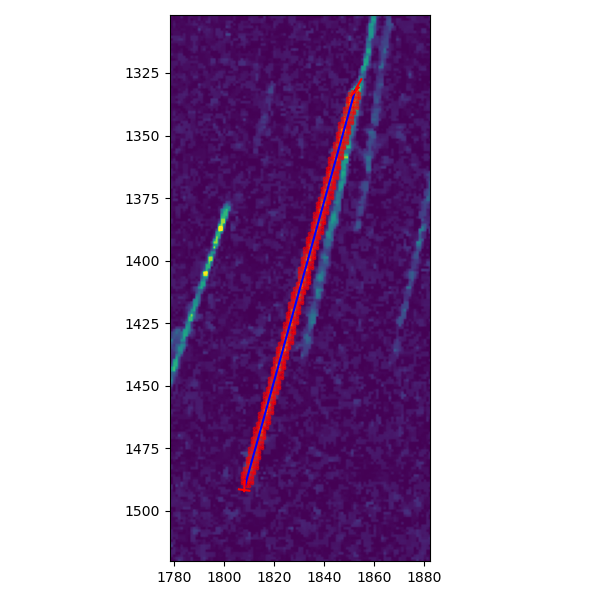

In [56]:
fline = generate_line(int(np.round(line.bounds.x0)), int(np.round(line.bounds.y0)),
                      image, struct.idxs)
fline2 = generate_line(int(np.round(line.bounds.x0 - np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y0 - np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)
bline = generate_line(int(np.round(line.bounds.x1)), int(np.round(line.bounds.y1)),
                         image, struct.idxs)
bline2 = generate_line(int(np.round(line.bounds.x1 + np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y1 + np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)

%matplotlib widget
offset = 30

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0.0, vmax=10)
ax.scatter(line.pixels.x, line.pixels.y, s=3, alpha=0.5, c='r')

ax.plot([line.bounds.x0, line.bounds.x1], [line.bounds.y0, line.bounds.y1], c='b')
ax.plot([fline.bounds.x0, fline.bounds.x1], [fline.bounds.y0, fline.bounds.y1], c='r')
ax.plot([fline2.bounds.x0, fline2.bounds.x1], [fline2.bounds.y0, fline2.bounds.y1], c='r')
ax.plot([bline.bounds.x0, bline.bounds.x1], [bline.bounds.y0, bline.bounds.y1], c='r')
ax.plot([bline2.bounds.x0, bline2.bounds.x1], [bline2.bounds.y0, bline2.bounds.y1], c='r')

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

In [45]:
from copy import deepcopy

index = 18
radius, rank = 2, 3
struct = Structure.new(radius=radius, rank=rank)

data = cbc.src.median_filter(frames[index], (3, 3))
new_image = Image.new(np.clip(data, 0.0, np.inf), struct)

In [35]:
image = deepcopy(new_image)

In [36]:
xtol = 1.1
max_iter, n_grow, log_eps, vmin = 1000, 100, np.log(1e-1), 0.9
min_size = 4

In [37]:
state = DetState.new_sparse(image, struct, vmin, 1)

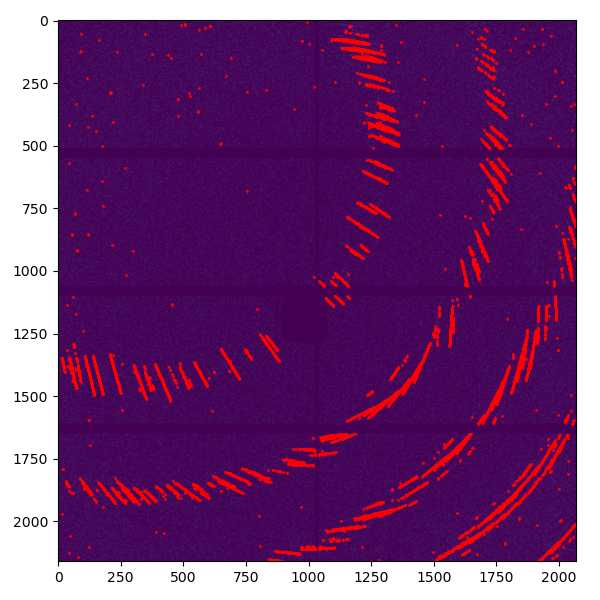

In [38]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0, vmax=10)
ax.scatter(state.x, state.y, s=1, c='r')

fig.tight_layout()
plt.show()

In [39]:
for _ in tqdm(range(max_iter), total=max_iter):
    x, y = state.next()
    line = region_grow(x, y, image, struct, n_grow, xtol, vmin, lookahead=2)
    x, y, val = cbc.src.draw_line_table(line.bounds.to_line(2 * struct.radius + 1), image.shape, profile='tophat')
    state.update(x[val > 0.0], y[val > 0.0])
    if log_nfa(line, xtol, min_size, xtol / (struct.radius + 0.5)) < log_eps:
        shrinked = line.shrink(0.7)
        if shrinked.pixels.moments.mu > vmin * shrinked.pixels.size:
            image.update(struct, x, y, val)
            state.lines.append(line)

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
len(state.lines)

226

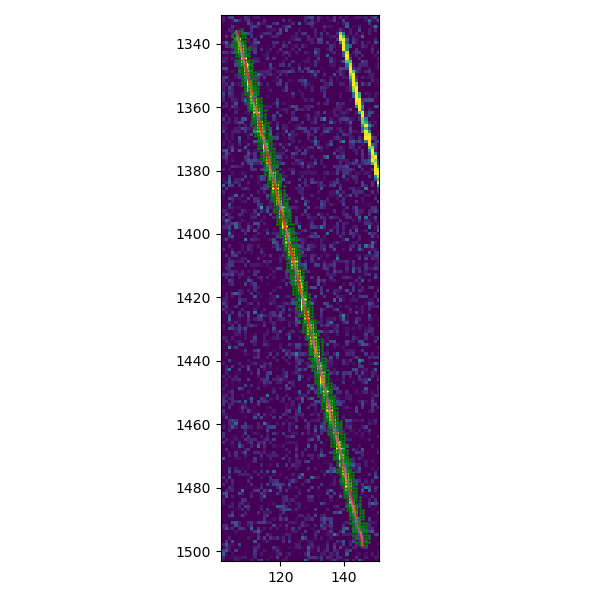

In [44]:
line = state.lines[1]
offset = 5

%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frames[index], vmin=0, vmax=10)
ax.plot(line.bounds.x, line.bounds.y, c='r')
ax.scatter(line.pixels.x, line.pixels.y, c='g', s=1)
for seed in line.linelets:
    ax.plot(seed.x, seed.y, alpha=0.5)

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

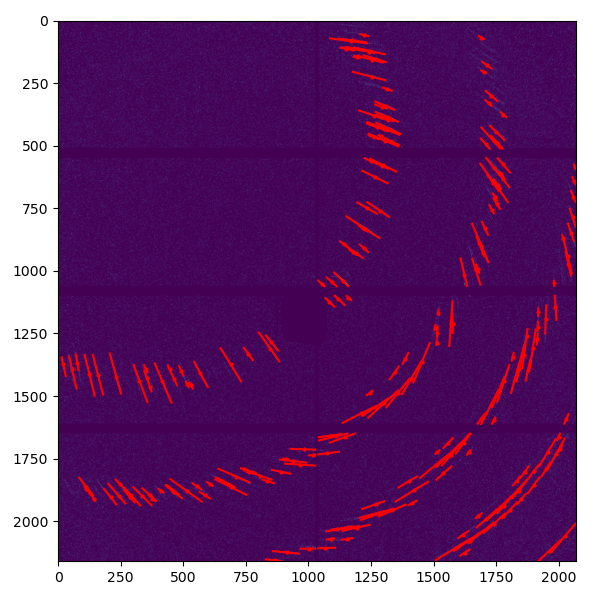

In [43]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(new_image.data[()], vmin=0, vmax=10)
for line in state.lines:
    ax.plot(line.bounds.x, line.bounds.y, c='r')
    ax.scatter(line.pixels.x0, line.pixels.y0, c='r', s=4)

ax.set_ylim(data.shape[0], 0)
ax.set_xlim(0, data.shape[1])
fig.tight_layout()
plt.show()